In [211]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
import copy

In [212]:
## TODO: convert date range to datetime column
## TODO: time series prediction for next X days (say next month)

In [213]:
obsidian_flames = pd.read_csv('Obsidian_Flames.csv', index_col = 'Unnamed: 0')
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,['Holofoil Market Price: '],7/18 to 7/20,$0.00
1,Absol ex - 135/197,['Holofoil Market Price: '],7/21 to 7/23,$0.00
2,Absol ex - 135/197,['Holofoil Market Price: '],7/24 to 7/26,$0.00
3,Absol ex - 135/197,['Holofoil Market Price: '],7/27 to 7/29,$0.00
4,Absol ex - 135/197,['Holofoil Market Price: '],7/30 to 8/1,$4.87
...,...,...,...,...
12925,Zigzagoon,['Reverse Holofoil Market Price: '],10/7 to 10/9,$0.06
12926,Zigzagoon,[' Market Price: '],10/10 to 10/12,$0.03
12927,Zigzagoon,['Reverse Holofoil Market Price: '],10/10 to 10/12,$0.06
12928,Zigzagoon,[' Market Price: '],10/13 to 10/15,$0.03


In [214]:
obsidian_flames['Foil'].unique()

array(["['Holofoil Market Price: ']", "[' Market Price: ']",
       "['Reverse Holofoil Market Price: ']"], dtype=object)

In [215]:
obsidian_flames.replace({'Foil' : { "[' Market Price: ']" : "Normal",
                               "['Reverse Holofoil Market Price: ']" : "Reverse Holofoil", 
                               "['Holofoil Market Price: ']" : "Holofoil"}}, inplace=True)
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/18 to 7/20,$0.00
1,Absol ex - 135/197,Holofoil,7/21 to 7/23,$0.00
2,Absol ex - 135/197,Holofoil,7/24 to 7/26,$0.00
3,Absol ex - 135/197,Holofoil,7/27 to 7/29,$0.00
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12926,Zigzagoon,Normal,10/10 to 10/12,$0.03
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06
12928,Zigzagoon,Normal,10/13 to 10/15,$0.03


In [216]:
sum(obsidian_flames['Market Price'] == "$0.00") / len(obsidian_flames['Market Price'] == "$0.00")
# Just 20% of the dataset has $0.00 market price

0.20471771075019335

In [217]:
of_cleaned = obsidian_flames[obsidian_flames['Market Price'] != '$0.00']
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12926,Zigzagoon,Normal,10/10 to 10/12,$0.03
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06
12928,Zigzagoon,Normal,10/13 to 10/15,$0.03


In [218]:
of_cleaned = of_cleaned.sort_values(by=['Product', 'Foil'])
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/1 to 10/3,$0.06
12923,Zigzagoon,Reverse Holofoil,10/4 to 10/6,$0.06
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06


In [219]:
of_cleaned['Market Price'] = of_cleaned['Market Price'].replace({'\$':''}, regex = True)
of_cleaned['Market Price'] = of_cleaned['Market Price'].astype(float)
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06
12923,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06


In [220]:
of_cleaned = of_cleaned.reset_index(drop=True)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
10278,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06
10279,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06
10280,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06
10281,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06


In [221]:
match_adj_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
match_adj_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
adj_match = [match_adj_product[i] and match_adj_foil[i] for i in range(len(match_adj_product))]
adj_mismatch = [not i for i in adj_match]
first_entries = adj_mismatch.copy()
first_entries.insert(0, True)
last_entries = adj_mismatch.copy()
last_entries.append(True)
first_market_price = of_cleaned[first_entries]['Market Price']
latest_market_price = of_cleaned[last_entries]['Market Price']
first_market_price = first_market_price.astype(float)
latest_market_price = latest_market_price.astype(float)
first_market_price = first_market_price.reset_index(drop=True)
latest_market_price = latest_market_price.reset_index(drop=True)

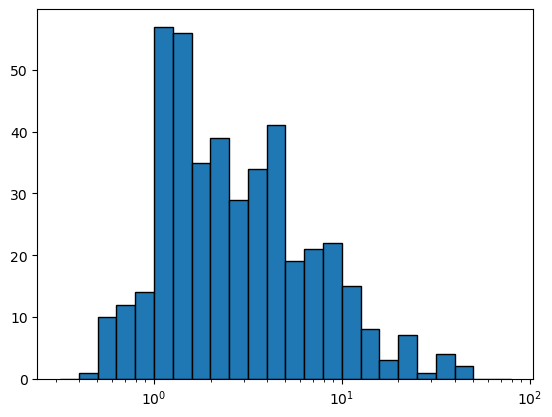

In [222]:
import matplotlib.pyplot as plt
initial_price_factor = [first_market_price[i]/latest_market_price[i] for i in range(len(latest_market_price))]
bins = 10**(.1*np.arange(-5,20))
plt.hist(initial_price_factor, bins=bins, edgecolor='black')
plt.xscale("log")
# seems that initial market prices are often several times higher than the price it settles at

In [223]:
sum([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))]) / len([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))])
# 54% of the initial prices are more than double the latest price in the dataset

0.541860465116279

In [224]:
def past_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        # whether product matches the product from the previous line
        match_prev_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        # whether foil matches the foil from the previous line
        match_prev_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the prev market price from the previous row
        if n == 0:
            prev_market_price = dataset['Market Price'][:-1]
        # otherwise take the latest next market price from the next row
        else:
            prev_market_price = dataset[f'Previous Market Price_{n}'][:-1]
            
        dataset = dataset[1:]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Previous Market Price_{n+1}'] = prev_market_price
        prev_match = [match_prev_product[i] and match_prev_foil[i] for i in range(len(match_prev_product))]
        dataset = dataset[prev_match]
        dataset = dataset.reset_index(drop=True)
    return dataset
        
        

In [225]:
def future_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_next_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_next_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the next market price from the next row
        if n == 0:
            next_market_price = dataset['Market Price'][1:]
        # otherwise take the latest next market price from the next row
        else:
            next_market_price = dataset[f'Next Market Price_{n}'][1:]
                    
        next_market_price = next_market_price.reset_index(drop=True)
        dataset = dataset[:-1]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Next Market Price_{n+1}'] = next_market_price
        next_match = [match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]
        dataset = dataset[next_match]
        dataset = dataset.reset_index(drop=True)
    return dataset

In [226]:
past_prices(2, of_cleaned)
# looks pretty good

,Product,Foil,Date Range,Market Price,Previous Market Price_1,Previous Market Price_2
0,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.86,0.80
...,...,...,...,...,...,...
9418,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06,0.06,0.07
9419,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06,0.06,0.06
9420,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06,0.06,0.06
9421,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06,0.06,0.06


In [227]:
future_prices(2, of_cleaned)

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87,4.74,4.74
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.74,2.04
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,2.04,0.80
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,0.80,0.86
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,0.86,0.81
...,...,...,...,...,...,...
9418,Zigzagoon,Reverse Holofoil,9/25 to 9/27,0.07,0.06,0.06
9419,Zigzagoon,Reverse Holofoil,9/28 to 9/30,0.06,0.06,0.06
9420,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06,0.06,0.06
9421,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06,0.06,0.06


In [228]:
# gets the next month of market prices
of_future_prices = future_prices(10, of_cleaned)
# obtains the last 15 days worth of prices
of_past_future_prices = past_prices(5, of_future_prices)
of_past_future_prices

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
3836,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07
3837,Zigzagoon,Reverse Holofoil,9/7 to 9/9,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.11,0.10,0.08,0.07,0.07
3838,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.10,0.11,0.10,0.08,0.07


# Data Split

In [229]:
of_past_future_prices['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15', '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13'], dtype=object)

In [230]:
# test set will contain everything from September 25th on
test = of_past_future_prices.loc[of_cleaned['Date Range'].isin(['9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'])]
train = of_past_future_prices.loc[of_cleaned['Date Range'].isin([ '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13', 
       '8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31'])]
test

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
11,Absol ex - 214/197,Holofoil,8/20 to 8/22,1.82,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.81,1.92,1.65,3.37,6.12
12,Absol ex - 214/197,Holofoil,8/23 to 8/25,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.82,1.81,1.92,1.65,3.37
13,Absol ex - 214/197,Holofoil,8/26 to 8/28,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.80,1.82,1.81,1.92,1.65
14,Absol ex - 214/197,Holofoil,8/29 to 8/31,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.73,1.50,1.80,1.82,1.81,1.92
15,Absol ex - 214/197,Holofoil,9/1 to 9/3,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.73,1.68,1.58,1.50,1.80,1.82,1.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,Zigzagoon,Reverse Holofoil,8/26 to 8/28,0.07,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.07,0.07,0.07,0.08,0.07
3834,Zigzagoon,Reverse Holofoil,8/29 to 8/31,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.07,0.07,0.07,0.07,0.08
3835,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
3836,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07


In [231]:
train

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
5,Absol ex - 135/197,Holofoil,8/29 to 8/31,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,1.16,0.93,0.92,0.81,0.81,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,Zigzagoon,Normal,9/4 to 9/6,0.04,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.04,0.05,0.06,0.06
3829,Zigzagoon,Normal,9/7 to 9/9,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.04,0.03,0.04,0.05,0.06
3830,Zigzagoon,Normal,9/10 to 9/12,0.04,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.03,0.04,0.05
3831,Zigzagoon,Normal,9/13 to 9/15,0.04,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04,0.03,0.04


In [232]:
of_cleaned.iloc[5884]

Product         Obsidian Flames 3 Pack Blister [Eevee]
Foil                                            Normal
Date Range                                10/1 to 10/3
Market Price                                     15.01
Name: 5884, dtype: object

In [233]:
# removed 'Product' from X_test and X_train since some of the products between train and test don't match
X_test = test[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_test = test['Next Market Price_10'].astype(float)
X_train = train[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_train = train['Next Market Price_10'].astype(float)

In [234]:
X_test = pd.get_dummies(X_test, columns = ['Foil'])
X_train = pd.get_dummies(X_train, columns = ['Foil'])

# Linear Regression

In [235]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [236]:
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_))
coefficients

,0,1
0,Previous Market Price_1,-0.572172
1,Previous Market Price_2,0.270944
2,Previous Market Price_3,-0.032726
3,Previous Market Price_4,0.005570
4,Previous Market Price_5,0.078941
5,Market Price,1.195024
6,Foil_Holofoil,-0.102611
7,Foil_Normal,-0.123918
8,Foil_Reverse Holofoil,0.226529


In [237]:
y_pred = classifier.predict(X_test)

In [238]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [239]:
regression_results(y_test, y_pred)
# over 98% of variance explained which makes sense given that it has access to previous values

explained_variance:  0.9883
r2:  0.9883
MAE:  0.57
MSE:  7.1737
RMSE:  2.6784


# LSTM

In [240]:
X_train = train[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_train = row_list
X_test = test[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_test = row_list
# y_train = train[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_train = row_list
# y_test = test[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_test = row_list

In [241]:
X_train['Market Price']

1       0.81
2       0.81
3       0.92
4       0.93
5       1.01
        ... 
3828    0.04
3829    0.04
3830    0.04
3831    0.04
3832    0.07
Name: Market Price, Length: 1404, dtype: float64

In [244]:
# need a many to many lstm
# https://github.com/keras-team/keras/issues/6063
from keras import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
model = Sequential()  
model.add(LSTM(32, input_dim=1, return_sequences=False))  
model.add(Dense(1, activation='linear'))
# model.add(Activation('linear'))   
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])  

In [245]:
history = model.fit(X_train, y_train,epochs=5000)

Epoch 1/5000
44/44 [==============================] - 2s 3ms/step - loss: 1922.9286 - mean_squared_error: 1922.9286
Epoch 2/5000
44/44 [==============================] - 0s 3ms/step - loss: 1911.1880 - mean_squared_error: 1911.1880
Epoch 3/5000
44/44 [==============================] - 0s 3ms/step - loss: 1899.4872 - mean_squared_error: 1899.4872
Epoch 4/5000
44/44 [==============================] - 0s 2ms/step - loss: 1881.8738 - mean_squared_error: 1881.8738
Epoch 5/5000
44/44 [==============================] - 0s 3ms/step - loss: 1862.3610 - mean_squared_error: 1862.3610
Epoch 6/5000
44/44 [==============================] - 0s 3ms/step - loss: 1849.7281 - mean_squared_error: 1849.7281
Epoch 7/5000
44/44 [==============================] - 0s 3ms/step - loss: 1840.0383 - mean_squared_error: 1840.0383
Epoch 8/5000
44/44 [==============================] - 0s 3ms/step - loss: 1824.1907 - mean_squared_error: 1824.1907
Epoch 9/5000
44/44 [==============================] - 0s 4ms/step - loss

44/44 [==============================] - 0s 3ms/step - loss: 1512.5575 - mean_squared_error: 1512.5575
Epoch 72/5000
44/44 [==============================] - 0s 2ms/step - loss: 1508.3834 - mean_squared_error: 1508.3834
Epoch 73/5000
44/44 [==============================] - 0s 3ms/step - loss: 1504.6627 - mean_squared_error: 1504.6627
Epoch 74/5000
44/44 [==============================] - 0s 3ms/step - loss: 1500.3031 - mean_squared_error: 1500.3031
Epoch 75/5000
44/44 [==============================] - 0s 2ms/step - loss: 1495.7761 - mean_squared_error: 1495.7761
Epoch 76/5000
44/44 [==============================] - 0s 2ms/step - loss: 1491.8832 - mean_squared_error: 1491.8832
Epoch 77/5000
44/44 [==============================] - 0s 3ms/step - loss: 1488.7631 - mean_squared_error: 1488.7631
Epoch 78/5000
44/44 [==============================] - 0s 3ms/step - loss: 1484.9084 - mean_squared_error: 1484.9084
Epoch 79/5000
44/44 [==============================] - 0s 3ms/step - loss: 148

44/44 [==============================] - 0s 2ms/step - loss: 1272.3518 - mean_squared_error: 1272.3518
Epoch 141/5000
44/44 [==============================] - 0s 2ms/step - loss: 1269.7361 - mean_squared_error: 1269.7361
Epoch 142/5000
44/44 [==============================] - 0s 3ms/step - loss: 1266.6282 - mean_squared_error: 1266.6282
Epoch 143/5000
44/44 [==============================] - 0s 3ms/step - loss: 1263.4623 - mean_squared_error: 1263.4623
Epoch 144/5000
44/44 [==============================] - 0s 3ms/step - loss: 1261.1362 - mean_squared_error: 1261.1362
Epoch 145/5000
44/44 [==============================] - 0s 3ms/step - loss: 1258.1487 - mean_squared_error: 1258.1486
Epoch 146/5000
44/44 [==============================] - 0s 2ms/step - loss: 1255.2002 - mean_squared_error: 1255.2002
Epoch 147/5000
44/44 [==============================] - 0s 2ms/step - loss: 1252.3607 - mean_squared_error: 1252.3607
Epoch 148/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 1093.7893 - mean_squared_error: 1093.7893
Epoch 210/5000
44/44 [==============================] - 0s 2ms/step - loss: 1091.4333 - mean_squared_error: 1091.4333
Epoch 211/5000
44/44 [==============================] - 0s 2ms/step - loss: 1088.7639 - mean_squared_error: 1088.7639
Epoch 212/5000
44/44 [==============================] - 0s 2ms/step - loss: 1086.1743 - mean_squared_error: 1086.1743
Epoch 213/5000
44/44 [==============================] - 0s 2ms/step - loss: 1086.0771 - mean_squared_error: 1086.0771
Epoch 214/5000
44/44 [==============================] - 0s 2ms/step - loss: 1081.0687 - mean_squared_error: 1081.0687
Epoch 215/5000
44/44 [==============================] - 0s 2ms/step - loss: 1079.0176 - mean_squared_error: 1079.0176
Epoch 216/5000
44/44 [==============================] - 0s 2ms/step - loss: 1075.9010 - mean_squared_error: 1075.9010
Epoch 217/5000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 926.2487 - mean_squared_error: 926.2487
Epoch 280/5000
44/44 [==============================] - 0s 2ms/step - loss: 923.9485 - mean_squared_error: 923.9485
Epoch 281/5000
44/44 [==============================] - 0s 2ms/step - loss: 921.9460 - mean_squared_error: 921.9460
Epoch 282/5000
44/44 [==============================] - 0s 2ms/step - loss: 920.1603 - mean_squared_error: 920.1603
Epoch 283/5000
44/44 [==============================] - 0s 2ms/step - loss: 917.7176 - mean_squared_error: 917.7176
Epoch 284/5000
44/44 [==============================] - 0s 2ms/step - loss: 915.2353 - mean_squared_error: 915.2353
Epoch 285/5000
44/44 [==============================] - 0s 2ms/step - loss: 912.8670 - mean_squared_error: 912.8670
Epoch 286/5000
44/44 [==============================] - 0s 2ms/step - loss: 910.4756 - mean_squared_error: 910.4756
Epoch 287/5000
44/44 [==============================] - 0s 2ms/step - loss: 907.9625 - 

44/44 [==============================] - 0s 2ms/step - loss: 776.3356 - mean_squared_error: 776.3356
Epoch 350/5000
44/44 [==============================] - 0s 3ms/step - loss: 773.5623 - mean_squared_error: 773.5623
Epoch 351/5000
44/44 [==============================] - 0s 2ms/step - loss: 775.5999 - mean_squared_error: 775.5999
Epoch 352/5000
44/44 [==============================] - 0s 2ms/step - loss: 770.2520 - mean_squared_error: 770.2520
Epoch 353/5000
44/44 [==============================] - 0s 2ms/step - loss: 767.7933 - mean_squared_error: 767.7933
Epoch 354/5000
44/44 [==============================] - 0s 2ms/step - loss: 765.8544 - mean_squared_error: 765.8544
Epoch 355/5000
44/44 [==============================] - 0s 2ms/step - loss: 766.2481 - mean_squared_error: 766.2481
Epoch 356/5000
44/44 [==============================] - 0s 2ms/step - loss: 761.8849 - mean_squared_error: 761.8849
Epoch 357/5000
44/44 [==============================] - 0s 2ms/step - loss: 760.8028 - 

44/44 [==============================] - 0s 2ms/step - loss: 640.4731 - mean_squared_error: 640.4731
Epoch 420/5000
44/44 [==============================] - 0s 2ms/step - loss: 638.4286 - mean_squared_error: 638.4286
Epoch 421/5000
44/44 [==============================] - 0s 2ms/step - loss: 638.6165 - mean_squared_error: 638.6165
Epoch 422/5000
44/44 [==============================] - 0s 2ms/step - loss: 634.4349 - mean_squared_error: 634.4349
Epoch 423/5000
44/44 [==============================] - 0s 2ms/step - loss: 634.1971 - mean_squared_error: 634.1971
Epoch 424/5000
44/44 [==============================] - 0s 3ms/step - loss: 630.6110 - mean_squared_error: 630.6110
Epoch 425/5000
44/44 [==============================] - 0s 2ms/step - loss: 628.7374 - mean_squared_error: 628.7374
Epoch 426/5000
44/44 [==============================] - 0s 3ms/step - loss: 629.6310 - mean_squared_error: 629.6310
Epoch 427/5000
44/44 [==============================] - 0s 2ms/step - loss: 625.4958 - 

44/44 [==============================] - 0s 3ms/step - loss: 521.3752 - mean_squared_error: 521.3752
Epoch 490/5000
44/44 [==============================] - 0s 2ms/step - loss: 519.6035 - mean_squared_error: 519.6035
Epoch 491/5000
44/44 [==============================] - 0s 3ms/step - loss: 518.4399 - mean_squared_error: 518.4399
Epoch 492/5000
44/44 [==============================] - 0s 2ms/step - loss: 516.4152 - mean_squared_error: 516.4152
Epoch 493/5000
44/44 [==============================] - 0s 2ms/step - loss: 514.3185 - mean_squared_error: 514.3185
Epoch 494/5000
44/44 [==============================] - 0s 2ms/step - loss: 521.9775 - mean_squared_error: 521.9775
Epoch 495/5000
44/44 [==============================] - 0s 2ms/step - loss: 515.5137 - mean_squared_error: 515.5137
Epoch 496/5000
44/44 [==============================] - 0s 2ms/step - loss: 513.5886 - mean_squared_error: 513.5886
Epoch 497/5000
44/44 [==============================] - 0s 2ms/step - loss: 509.9750 - 

44/44 [==============================] - 0s 2ms/step - loss: 416.7142 - mean_squared_error: 416.7142
Epoch 560/5000
44/44 [==============================] - 0s 2ms/step - loss: 415.3938 - mean_squared_error: 415.3938
Epoch 561/5000
44/44 [==============================] - 0s 2ms/step - loss: 413.8076 - mean_squared_error: 413.8076
Epoch 562/5000
44/44 [==============================] - 0s 2ms/step - loss: 414.0855 - mean_squared_error: 414.0855
Epoch 563/5000
44/44 [==============================] - 0s 2ms/step - loss: 410.8787 - mean_squared_error: 410.8787
Epoch 564/5000
44/44 [==============================] - 0s 2ms/step - loss: 409.6307 - mean_squared_error: 409.6307
Epoch 565/5000
44/44 [==============================] - 0s 2ms/step - loss: 408.2307 - mean_squared_error: 408.2307
Epoch 566/5000
44/44 [==============================] - 0s 2ms/step - loss: 407.0555 - mean_squared_error: 407.0555
Epoch 567/5000
44/44 [==============================] - 0s 2ms/step - loss: 405.8525 - 

44/44 [==============================] - 0s 2ms/step - loss: 328.5483 - mean_squared_error: 328.5483
Epoch 630/5000
44/44 [==============================] - 0s 3ms/step - loss: 325.9076 - mean_squared_error: 325.9076
Epoch 631/5000
44/44 [==============================] - 0s 2ms/step - loss: 324.9080 - mean_squared_error: 324.9080
Epoch 632/5000
44/44 [==============================] - 0s 3ms/step - loss: 323.5958 - mean_squared_error: 323.5958
Epoch 633/5000
44/44 [==============================] - 0s 3ms/step - loss: 322.7439 - mean_squared_error: 322.7439
Epoch 634/5000
44/44 [==============================] - 0s 2ms/step - loss: 321.5093 - mean_squared_error: 321.5093
Epoch 635/5000
44/44 [==============================] - 0s 2ms/step - loss: 320.2113 - mean_squared_error: 320.2113
Epoch 636/5000
44/44 [==============================] - 0s 2ms/step - loss: 319.1369 - mean_squared_error: 319.1369
Epoch 637/5000
44/44 [==============================] - 0s 2ms/step - loss: 318.0194 - 

44/44 [==============================] - 0s 2ms/step - loss: 252.2937 - mean_squared_error: 252.2937
Epoch 700/5000
44/44 [==============================] - 0s 3ms/step - loss: 251.4012 - mean_squared_error: 251.4012
Epoch 701/5000
44/44 [==============================] - 0s 3ms/step - loss: 250.1700 - mean_squared_error: 250.1700
Epoch 702/5000
44/44 [==============================] - 0s 3ms/step - loss: 249.0425 - mean_squared_error: 249.0425
Epoch 703/5000
44/44 [==============================] - 0s 2ms/step - loss: 248.1449 - mean_squared_error: 248.1449
Epoch 704/5000
44/44 [==============================] - 0s 2ms/step - loss: 247.0443 - mean_squared_error: 247.0443
Epoch 705/5000
44/44 [==============================] - 0s 2ms/step - loss: 246.2313 - mean_squared_error: 246.2313
Epoch 706/5000
44/44 [==============================] - 0s 2ms/step - loss: 245.2410 - mean_squared_error: 245.2410
Epoch 707/5000
44/44 [==============================] - 0s 2ms/step - loss: 244.5535 - 

44/44 [==============================] - 0s 2ms/step - loss: 188.8077 - mean_squared_error: 188.8077
Epoch 770/5000
44/44 [==============================] - 0s 2ms/step - loss: 187.7443 - mean_squared_error: 187.7443
Epoch 771/5000
44/44 [==============================] - 0s 2ms/step - loss: 187.2700 - mean_squared_error: 187.2700
Epoch 772/5000
44/44 [==============================] - 0s 2ms/step - loss: 186.1386 - mean_squared_error: 186.1386
Epoch 773/5000
44/44 [==============================] - 0s 3ms/step - loss: 186.5350 - mean_squared_error: 186.5350
Epoch 774/5000
44/44 [==============================] - 0s 2ms/step - loss: 186.9123 - mean_squared_error: 186.9123
Epoch 775/5000
44/44 [==============================] - 0s 2ms/step - loss: 183.9544 - mean_squared_error: 183.9544
Epoch 776/5000
44/44 [==============================] - 0s 2ms/step - loss: 183.6651 - mean_squared_error: 183.6651
Epoch 777/5000
44/44 [==============================] - 0s 2ms/step - loss: 182.3932 - 

44/44 [==============================] - 0s 2ms/step - loss: 135.1809 - mean_squared_error: 135.1809
Epoch 840/5000
44/44 [==============================] - 0s 2ms/step - loss: 134.9654 - mean_squared_error: 134.9654
Epoch 841/5000
44/44 [==============================] - 0s 2ms/step - loss: 133.8914 - mean_squared_error: 133.8914
Epoch 842/5000
44/44 [==============================] - 0s 2ms/step - loss: 133.3175 - mean_squared_error: 133.3175
Epoch 843/5000
44/44 [==============================] - 0s 2ms/step - loss: 133.5710 - mean_squared_error: 133.5710
Epoch 844/5000
44/44 [==============================] - 0s 3ms/step - loss: 131.7415 - mean_squared_error: 131.7415
Epoch 845/5000
44/44 [==============================] - 0s 2ms/step - loss: 135.8655 - mean_squared_error: 135.8655
Epoch 846/5000
44/44 [==============================] - 0s 2ms/step - loss: 131.1206 - mean_squared_error: 131.1206
Epoch 847/5000
44/44 [==============================] - 0s 2ms/step - loss: 130.1369 - 

44/44 [==============================] - 0s 2ms/step - loss: 89.9623 - mean_squared_error: 89.9623
Epoch 911/5000
44/44 [==============================] - 0s 2ms/step - loss: 90.3446 - mean_squared_error: 90.3446
Epoch 912/5000
44/44 [==============================] - 0s 2ms/step - loss: 88.7650 - mean_squared_error: 88.7650
Epoch 913/5000
44/44 [==============================] - 0s 2ms/step - loss: 89.4563 - mean_squared_error: 89.4563
Epoch 914/5000
44/44 [==============================] - 0s 2ms/step - loss: 87.5041 - mean_squared_error: 87.5041
Epoch 915/5000
44/44 [==============================] - 0s 2ms/step - loss: 86.9195 - mean_squared_error: 86.9195
Epoch 916/5000
44/44 [==============================] - 0s 2ms/step - loss: 86.9539 - mean_squared_error: 86.9539
Epoch 917/5000
44/44 [==============================] - 0s 2ms/step - loss: 86.4302 - mean_squared_error: 86.4302
Epoch 918/5000
44/44 [==============================] - 0s 2ms/step - loss: 85.3485 - mean_squared_erro

Epoch 982/5000
44/44 [==============================] - 0s 2ms/step - loss: 53.7733 - mean_squared_error: 53.7733
Epoch 983/5000
44/44 [==============================] - 0s 3ms/step - loss: 52.5618 - mean_squared_error: 52.5618
Epoch 984/5000
44/44 [==============================] - 0s 3ms/step - loss: 54.4903 - mean_squared_error: 54.4903
Epoch 985/5000
44/44 [==============================] - 0s 3ms/step - loss: 52.6103 - mean_squared_error: 52.6103
Epoch 986/5000
44/44 [==============================] - 0s 2ms/step - loss: 52.2714 - mean_squared_error: 52.2714
Epoch 987/5000
44/44 [==============================] - 0s 2ms/step - loss: 51.3985 - mean_squared_error: 51.3985
Epoch 988/5000
44/44 [==============================] - 0s 2ms/step - loss: 50.9454 - mean_squared_error: 50.9454
Epoch 989/5000
44/44 [==============================] - 0s 2ms/step - loss: 51.5715 - mean_squared_error: 51.5715
Epoch 990/5000
44/44 [==============================] - 0s 2ms/step - loss: 50.4795 - me

44/44 [==============================] - 0s 2ms/step - loss: 26.7090 - mean_squared_error: 26.7090
Epoch 1054/5000
44/44 [==============================] - 0s 2ms/step - loss: 26.3591 - mean_squared_error: 26.3591
Epoch 1055/5000
44/44 [==============================] - 0s 2ms/step - loss: 28.9690 - mean_squared_error: 28.9690
Epoch 1056/5000
44/44 [==============================] - 0s 2ms/step - loss: 26.1794 - mean_squared_error: 26.1794
Epoch 1057/5000
44/44 [==============================] - 0s 2ms/step - loss: 26.2685 - mean_squared_error: 26.2685
Epoch 1058/5000
44/44 [==============================] - 0s 2ms/step - loss: 27.1485 - mean_squared_error: 27.1485
Epoch 1059/5000
44/44 [==============================] - 0s 2ms/step - loss: 25.1719 - mean_squared_error: 25.1719
Epoch 1060/5000
44/44 [==============================] - 0s 2ms/step - loss: 24.8722 - mean_squared_error: 24.8722
Epoch 1061/5000
44/44 [==============================] - 0s 3ms/step - loss: 26.2126 - mean_squa

44/44 [==============================] - 0s 2ms/step - loss: 30.7095 - mean_squared_error: 30.7095
Epoch 1125/5000
44/44 [==============================] - 0s 2ms/step - loss: 15.5877 - mean_squared_error: 15.5877
Epoch 1126/5000
44/44 [==============================] - 0s 3ms/step - loss: 9.3015 - mean_squared_error: 9.3015
Epoch 1127/5000
44/44 [==============================] - 0s 3ms/step - loss: 9.1049 - mean_squared_error: 9.1049
Epoch 1128/5000
44/44 [==============================] - 0s 3ms/step - loss: 9.8483 - mean_squared_error: 9.8483
Epoch 1129/5000
44/44 [==============================] - 0s 3ms/step - loss: 9.3020 - mean_squared_error: 9.3020
Epoch 1130/5000
44/44 [==============================] - 0s 2ms/step - loss: 9.3775 - mean_squared_error: 9.3775
Epoch 1131/5000
44/44 [==============================] - 0s 2ms/step - loss: 8.5376 - mean_squared_error: 8.5376
Epoch 1132/5000
44/44 [==============================] - 0s 3ms/step - loss: 8.3558 - mean_squared_error: 8.

44/44 [==============================] - 0s 2ms/step - loss: 3.1078 - mean_squared_error: 3.1078
Epoch 1197/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.7977 - mean_squared_error: 1.7977
Epoch 1198/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.7911 - mean_squared_error: 1.7911
Epoch 1199/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.3598 - mean_squared_error: 2.3598
Epoch 1200/5000
44/44 [==============================] - 0s 3ms/step - loss: 6.0588 - mean_squared_error: 6.0588
Epoch 1201/5000
44/44 [==============================] - 0s 3ms/step - loss: 12.1633 - mean_squared_error: 12.1633
Epoch 1202/5000
44/44 [==============================] - 0s 3ms/step - loss: 10.3330 - mean_squared_error: 10.3330
Epoch 1203/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.0865 - mean_squared_error: 2.0865
Epoch 1204/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.4807 - mean_squared_error: 1.

44/44 [==============================] - 0s 2ms/step - loss: 1.3386 - mean_squared_error: 1.3386
Epoch 1269/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3065 - mean_squared_error: 0.3065
Epoch 1270/5000
44/44 [==============================] - 0s 2ms/step - loss: 5.6387 - mean_squared_error: 5.6387
Epoch 1271/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2594 - mean_squared_error: 0.2594
Epoch 1272/5000
44/44 [==============================] - 0s 2ms/step - loss: 5.1273 - mean_squared_error: 5.1273
Epoch 1273/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.9970 - mean_squared_error: 2.9970
Epoch 1274/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2588 - mean_squared_error: 0.2588
Epoch 1275/5000
44/44 [==============================] - 0s 3ms/step - loss: 3.6927 - mean_squared_error: 3.6927
Epoch 1276/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3253 - mean_squared_error: 0.3253

44/44 [==============================] - 0s 2ms/step - loss: 0.3274 - mean_squared_error: 0.3274
Epoch 1341/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3251 - mean_squared_error: 0.3251
Epoch 1342/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.0255 - mean_squared_error: 1.0255
Epoch 1343/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.0395 - mean_squared_error: 2.0395
Epoch 1344/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2617 - mean_squared_error: 0.2617
Epoch 1345/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1902 - mean_squared_error: 0.1902
Epoch 1346/5000
44/44 [==============================] - 0s 3ms/step - loss: 9.7183 - mean_squared_error: 9.7183
Epoch 1347/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.0250 - mean_squared_error: 1.0250
Epoch 1348/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3192 - mean_squared_error: 0.3192

44/44 [==============================] - 0s 3ms/step - loss: 2.0885 - mean_squared_error: 2.0885
Epoch 1413/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1470 - mean_squared_error: 0.1470
Epoch 1414/5000
44/44 [==============================] - 0s 2ms/step - loss: 8.4244 - mean_squared_error: 8.4244
Epoch 1415/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3460 - mean_squared_error: 0.3460
Epoch 1416/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2580 - mean_squared_error: 0.2580
Epoch 1417/5000
44/44 [==============================] - 0s 3ms/step - loss: 3.2313 - mean_squared_error: 3.2313
Epoch 1418/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2970 - mean_squared_error: 0.2970
Epoch 1419/5000
44/44 [==============================] - 0s 3ms/step - loss: 6.3450 - mean_squared_error: 6.3450
Epoch 1420/5000
44/44 [==============================] - 0s 3ms/step - loss: 6.4237 - mean_squared_error: 6.4237

44/44 [==============================] - 0s 2ms/step - loss: 1.1467 - mean_squared_error: 1.1467
Epoch 1485/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.1122 - mean_squared_error: 1.1122
Epoch 1486/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.4105 - mean_squared_error: 0.4105
Epoch 1487/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.9844 - mean_squared_error: 0.9844
Epoch 1488/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2108 - mean_squared_error: 0.2108
Epoch 1489/5000
44/44 [==============================] - 0s 3ms/step - loss: 4.3371 - mean_squared_error: 4.3371
Epoch 1490/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.3392 - mean_squared_error: 1.3392
Epoch 1491/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.5798 - mean_squared_error: 0.5798
Epoch 1492/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.5311 - mean_squared_error: 0.5311

44/44 [==============================] - 0s 2ms/step - loss: 0.2310 - mean_squared_error: 0.2310
Epoch 1557/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2043 - mean_squared_error: 0.2043
Epoch 1558/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.9067 - mean_squared_error: 1.9067
Epoch 1559/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.7186 - mean_squared_error: 0.7186
Epoch 1560/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6537 - mean_squared_error: 0.6537
Epoch 1561/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.2419 - mean_squared_error: 2.2419
Epoch 1562/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2191 - mean_squared_error: 0.2191
Epoch 1563/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.6910 - mean_squared_error: 1.6910
Epoch 1564/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2332 - mean_squared_error: 0.2332

44/44 [==============================] - 0s 2ms/step - loss: 0.2003 - mean_squared_error: 0.2003
Epoch 1629/5000
44/44 [==============================] - 0s 2ms/step - loss: 3.7936 - mean_squared_error: 3.7936
Epoch 1630/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2032 - mean_squared_error: 0.2032
Epoch 1631/5000
44/44 [==============================] - 0s 2ms/step - loss: 3.0922 - mean_squared_error: 3.0922
Epoch 1632/5000
44/44 [==============================] - 0s 3ms/step - loss: 4.0678 - mean_squared_error: 4.0678
Epoch 1633/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2041 - mean_squared_error: 0.2041
Epoch 1634/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.0483 - mean_squared_error: 1.0483
Epoch 1635/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3141 - mean_squared_error: 0.3141
Epoch 1636/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1913 - mean_squared_error: 0.1913

44/44 [==============================] - 0s 2ms/step - loss: 2.1854 - mean_squared_error: 2.1854
Epoch 1701/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.1330 - mean_squared_error: 2.1330
Epoch 1702/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.9808 - mean_squared_error: 1.9808
Epoch 1703/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.8756 - mean_squared_error: 1.8756
Epoch 1704/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.7080 - mean_squared_error: 2.7080
Epoch 1705/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.7476 - mean_squared_error: 1.7476
Epoch 1706/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.7083 - mean_squared_error: 1.7083
Epoch 1707/5000
44/44 [==============================] - 0s 2ms/step - loss: 4.9588 - mean_squared_error: 4.9588
Epoch 1708/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.5285 - mean_squared_error: 1.5285

44/44 [==============================] - 0s 2ms/step - loss: 1.9296 - mean_squared_error: 1.9296
Epoch 1773/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2337 - mean_squared_error: 0.2337
Epoch 1774/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.7334 - mean_squared_error: 1.7334
Epoch 1775/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.2158 - mean_squared_error: 1.2158
Epoch 1776/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.8218 - mean_squared_error: 0.8218
Epoch 1777/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1819 - mean_squared_error: 0.1819
Epoch 1778/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2095 - mean_squared_error: 0.2095
Epoch 1779/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6670 - mean_squared_error: 0.6670
Epoch 1780/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1768 - mean_squared_error: 0.1768

44/44 [==============================] - 0s 2ms/step - loss: 1.2969 - mean_squared_error: 1.2969
Epoch 1845/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2040 - mean_squared_error: 0.2040
Epoch 1846/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2600 - mean_squared_error: 0.2600
Epoch 1847/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.5267 - mean_squared_error: 1.5267
Epoch 1848/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2582 - mean_squared_error: 0.2582
Epoch 1849/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.2283 - mean_squared_error: 1.2283
Epoch 1850/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.4091 - mean_squared_error: 0.4091
Epoch 1851/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.2130 - mean_squared_error: 1.2130
Epoch 1852/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1789 - mean_squared_error: 0.1789

44/44 [==============================] - 0s 2ms/step - loss: 3.2833 - mean_squared_error: 3.2833
Epoch 1917/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.7446 - mean_squared_error: 1.7446
Epoch 1918/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.4867 - mean_squared_error: 1.4867
Epoch 1919/5000
44/44 [==============================] - 0s 2ms/step - loss: 2.7032 - mean_squared_error: 2.7032
Epoch 1920/5000
44/44 [==============================] - 0s 2ms/step - loss: 2.8049 - mean_squared_error: 2.8049
Epoch 1921/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.5899 - mean_squared_error: 1.5899
Epoch 1922/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6238 - mean_squared_error: 0.6238
Epoch 1923/5000
44/44 [==============================] - 0s 2ms/step - loss: 35.4003 - mean_squared_error: 35.4003
Epoch 1924/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.2522 - mean_squared_error: 1.25

44/44 [==============================] - 0s 3ms/step - loss: 0.2716 - mean_squared_error: 0.2716
Epoch 1989/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.5226 - mean_squared_error: 0.5226
Epoch 1990/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3135 - mean_squared_error: 0.3135
Epoch 1991/5000
44/44 [==============================] - 0s 3ms/step - loss: 7.7783 - mean_squared_error: 7.7783
Epoch 1992/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.2070 - mean_squared_error: 1.2070
Epoch 1993/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.8148 - mean_squared_error: 0.8148
Epoch 1994/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3249 - mean_squared_error: 0.3249
Epoch 1995/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.6739 - mean_squared_error: 1.6739
Epoch 1996/5000
44/44 [==============================] - 0s 3ms/step - loss: 7.0957 - mean_squared_error: 7.0957

44/44 [==============================] - 0s 3ms/step - loss: 7.1623 - mean_squared_error: 7.1623
Epoch 2061/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.9511 - mean_squared_error: 1.9511
Epoch 2062/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.9478 - mean_squared_error: 1.9478
Epoch 2063/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.4471 - mean_squared_error: 1.4471
Epoch 2064/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.3000 - mean_squared_error: 2.3000
Epoch 2065/5000
44/44 [==============================] - 0s 2ms/step - loss: 13.7775 - mean_squared_error: 13.7775
Epoch 2066/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3477 - mean_squared_error: 0.3477
Epoch 2067/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.3805 - mean_squared_error: 1.3805
Epoch 2068/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3684 - mean_squared_error: 0.36

44/44 [==============================] - 0s 2ms/step - loss: 0.3232 - mean_squared_error: 0.3232
Epoch 2133/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1887 - mean_squared_error: 0.1887
Epoch 2134/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.9148 - mean_squared_error: 0.9148
Epoch 2135/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1702 - mean_squared_error: 0.1702
Epoch 2136/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1712 - mean_squared_error: 0.1712
Epoch 2137/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.4095 - mean_squared_error: 1.4095
Epoch 2138/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.5028 - mean_squared_error: 0.5028
Epoch 2139/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4021 - mean_squared_error: 0.4021
Epoch 2140/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.5097 - mean_squared_error: 0.5097

44/44 [==============================] - 0s 2ms/step - loss: 1.1915 - mean_squared_error: 1.1915
Epoch 2205/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3855 - mean_squared_error: 0.3855
Epoch 2206/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6570 - mean_squared_error: 0.6570
Epoch 2207/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2588 - mean_squared_error: 0.2588
Epoch 2208/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.0820 - mean_squared_error: 2.0820
Epoch 2209/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3305 - mean_squared_error: 0.3305
Epoch 2210/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.1258 - mean_squared_error: 1.1258
Epoch 2211/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1999 - mean_squared_error: 0.1999
Epoch 2212/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.2098 - mean_squared_error: 1.2098

44/44 [==============================] - 0s 2ms/step - loss: 0.2914 - mean_squared_error: 0.2914
Epoch 2277/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1809 - mean_squared_error: 0.1809
Epoch 2278/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1603 - mean_squared_error: 0.1603
Epoch 2279/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.9012 - mean_squared_error: 0.9012
Epoch 2280/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.4780 - mean_squared_error: 1.4780
Epoch 2281/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1824 - mean_squared_error: 0.1824
Epoch 2282/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3926 - mean_squared_error: 0.3926
Epoch 2283/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1674 - mean_squared_error: 0.1674
Epoch 2284/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1700 - mean_squared_error: 0.1700

44/44 [==============================] - 0s 2ms/step - loss: 0.9455 - mean_squared_error: 0.9455
Epoch 2349/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2084 - mean_squared_error: 0.2084
Epoch 2350/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.1819 - mean_squared_error: 1.1819
Epoch 2351/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2581 - mean_squared_error: 0.2581
Epoch 2352/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3675 - mean_squared_error: 0.3675
Epoch 2353/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2140 - mean_squared_error: 0.2140
Epoch 2354/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2014 - mean_squared_error: 0.2014
Epoch 2355/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1853 - mean_squared_error: 0.1853
Epoch 2356/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.4817 - mean_squared_error: 0.4817

44/44 [==============================] - 0s 3ms/step - loss: 0.1821 - mean_squared_error: 0.1821
Epoch 2421/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2525 - mean_squared_error: 0.2525
Epoch 2422/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.1369 - mean_squared_error: 1.1369
Epoch 2423/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2594 - mean_squared_error: 0.2594
Epoch 2424/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1747 - mean_squared_error: 0.1747
Epoch 2425/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.8466 - mean_squared_error: 1.8466
Epoch 2426/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3161 - mean_squared_error: 0.3161
Epoch 2427/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2420 - mean_squared_error: 0.2420
Epoch 2428/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1863 - mean_squared_error: 0.1863

44/44 [==============================] - 0s 3ms/step - loss: 0.1710 - mean_squared_error: 0.1710
Epoch 2493/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6776 - mean_squared_error: 0.6776
Epoch 2494/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2474 - mean_squared_error: 0.2474
Epoch 2495/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2037 - mean_squared_error: 0.2037
Epoch 2496/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1876 - mean_squared_error: 0.1876
Epoch 2497/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.8519 - mean_squared_error: 0.8519
Epoch 2498/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1686 - mean_squared_error: 0.1686
Epoch 2499/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.1200 - mean_squared_error: 1.1200
Epoch 2500/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1846 - mean_squared_error: 0.1846

44/44 [==============================] - 0s 3ms/step - loss: 0.2268 - mean_squared_error: 0.2268
Epoch 2565/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1808 - mean_squared_error: 0.1808
Epoch 2566/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.7609 - mean_squared_error: 0.7609
Epoch 2567/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4776 - mean_squared_error: 0.4776
Epoch 2568/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1339 - mean_squared_error: 0.1339
Epoch 2569/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.0581 - mean_squared_error: 1.0581
Epoch 2570/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1524 - mean_squared_error: 0.1524
Epoch 2571/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2511 - mean_squared_error: 0.2511
Epoch 2572/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1932 - mean_squared_error: 0.1932

44/44 [==============================] - 0s 3ms/step - loss: 0.5675 - mean_squared_error: 0.5675
Epoch 2637/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1472 - mean_squared_error: 0.1472
Epoch 2638/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2767 - mean_squared_error: 0.2767
Epoch 2639/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.0594 - mean_squared_error: 1.0594
Epoch 2640/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4306 - mean_squared_error: 0.4306
Epoch 2641/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1859 - mean_squared_error: 0.1859
Epoch 2642/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6420 - mean_squared_error: 0.6420
Epoch 2643/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1642 - mean_squared_error: 0.1642
Epoch 2644/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1574 - mean_squared_error: 0.1574

44/44 [==============================] - 0s 3ms/step - loss: 0.1762 - mean_squared_error: 0.1762
Epoch 2709/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3858 - mean_squared_error: 0.3858
Epoch 2710/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1419 - mean_squared_error: 0.1419
Epoch 2711/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1846 - mean_squared_error: 0.1846
Epoch 2712/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1619 - mean_squared_error: 0.1619
Epoch 2713/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1667 - mean_squared_error: 0.1667
Epoch 2714/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.8330 - mean_squared_error: 0.8330
Epoch 2715/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2427 - mean_squared_error: 0.2427
Epoch 2716/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1701 - mean_squared_error: 0.1701

44/44 [==============================] - 0s 3ms/step - loss: 0.1601 - mean_squared_error: 0.1601
Epoch 2781/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2400 - mean_squared_error: 0.2400
Epoch 2782/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4830 - mean_squared_error: 0.4830
Epoch 2783/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1533 - mean_squared_error: 0.1533
Epoch 2784/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.5895 - mean_squared_error: 1.5895
Epoch 2785/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2301 - mean_squared_error: 0.2301
Epoch 2786/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.2600 - mean_squared_error: 1.2600
Epoch 2787/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1926 - mean_squared_error: 0.1926
Epoch 2788/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4374 - mean_squared_error: 0.4374

44/44 [==============================] - 0s 3ms/step - loss: 0.3490 - mean_squared_error: 0.3490
Epoch 2853/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.5557 - mean_squared_error: 1.5557
Epoch 2854/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6465 - mean_squared_error: 0.6465
Epoch 2855/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.7018 - mean_squared_error: 1.7018
Epoch 2856/5000
44/44 [==============================] - 0s 2ms/step - loss: 2.5419 - mean_squared_error: 2.5419
Epoch 2857/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3769 - mean_squared_error: 0.3769
Epoch 2858/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6351 - mean_squared_error: 0.6351
Epoch 2859/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.6326 - mean_squared_error: 1.6326
Epoch 2860/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.8995 - mean_squared_error: 2.8995

44/44 [==============================] - 0s 3ms/step - loss: 0.1584 - mean_squared_error: 0.1584
Epoch 2925/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2329 - mean_squared_error: 0.2329
Epoch 2926/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.4685 - mean_squared_error: 0.4685
Epoch 2927/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.7507 - mean_squared_error: 0.7507
Epoch 2928/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1909 - mean_squared_error: 0.1909
Epoch 2929/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1406 - mean_squared_error: 0.1406
Epoch 2930/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1524 - mean_squared_error: 0.1524
Epoch 2931/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.9049 - mean_squared_error: 0.9049
Epoch 2932/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.0378 - mean_squared_error: 2.0378

44/44 [==============================] - 0s 3ms/step - loss: 0.3678 - mean_squared_error: 0.3678
Epoch 2997/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2959 - mean_squared_error: 0.2959
Epoch 2998/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2425 - mean_squared_error: 0.2425
Epoch 2999/5000
44/44 [==============================] - 0s 4ms/step - loss: 0.1679 - mean_squared_error: 0.1679
Epoch 3000/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4269 - mean_squared_error: 0.4269
Epoch 3001/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1524 - mean_squared_error: 0.1524
Epoch 3002/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1639 - mean_squared_error: 0.1639
Epoch 3003/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1678 - mean_squared_error: 0.1678
Epoch 3004/5000
44/44 [==============================] - 0s 2ms/step - loss: 2.4026 - mean_squared_error: 2.4026

44/44 [==============================] - 0s 3ms/step - loss: 0.1635 - mean_squared_error: 0.1635
Epoch 3069/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.2943 - mean_squared_error: 1.2943
Epoch 3070/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3845 - mean_squared_error: 0.3845
Epoch 3071/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1538 - mean_squared_error: 0.1538
Epoch 3072/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1509 - mean_squared_error: 0.1509
Epoch 3073/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2591 - mean_squared_error: 0.2591
Epoch 3074/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1625 - mean_squared_error: 0.1625
Epoch 3075/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2566 - mean_squared_error: 0.2566
Epoch 3076/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4642 - mean_squared_error: 0.4642

44/44 [==============================] - 0s 3ms/step - loss: 1.0630 - mean_squared_error: 1.0630
Epoch 3141/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1667 - mean_squared_error: 0.1667
Epoch 3142/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4950 - mean_squared_error: 0.4950
Epoch 3143/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1597 - mean_squared_error: 0.1597
Epoch 3144/5000
44/44 [==============================] - 0s 4ms/step - loss: 0.1382 - mean_squared_error: 0.1382
Epoch 3145/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2994 - mean_squared_error: 0.2994
Epoch 3146/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1531 - mean_squared_error: 0.1531
Epoch 3147/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1504 - mean_squared_error: 0.1504
Epoch 3148/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1486 - mean_squared_error: 0.1486

44/44 [==============================] - 0s 4ms/step - loss: 0.2202 - mean_squared_error: 0.2202
Epoch 3213/5000
44/44 [==============================] - 0s 4ms/step - loss: 0.3036 - mean_squared_error: 0.3036
Epoch 3214/5000
44/44 [==============================] - 0s 4ms/step - loss: 0.1651 - mean_squared_error: 0.1651
Epoch 3215/5000
44/44 [==============================] - 0s 4ms/step - loss: 0.1457 - mean_squared_error: 0.1457
Epoch 3216/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3937 - mean_squared_error: 0.3937
Epoch 3217/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4060 - mean_squared_error: 0.4060
Epoch 3218/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1486 - mean_squared_error: 0.1486
Epoch 3219/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1851 - mean_squared_error: 0.1851
Epoch 3220/5000
44/44 [==============================] - 0s 5ms/step - loss: 0.1608 - mean_squared_error: 0.1608

44/44 [==============================] - 0s 3ms/step - loss: 0.6998 - mean_squared_error: 0.6998
Epoch 3285/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1345 - mean_squared_error: 0.1345
Epoch 3286/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1298 - mean_squared_error: 0.1298
Epoch 3287/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.2543 - mean_squared_error: 2.2543
Epoch 3288/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3680 - mean_squared_error: 0.3680
Epoch 3289/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.9319 - mean_squared_error: 1.9319
Epoch 3290/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3117 - mean_squared_error: 0.3117
Epoch 3291/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4153 - mean_squared_error: 0.4153
Epoch 3292/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2565 - mean_squared_error: 0.2565

44/44 [==============================] - 0s 3ms/step - loss: 0.1567 - mean_squared_error: 0.1567
Epoch 3357/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.5638 - mean_squared_error: 0.5638
Epoch 3358/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1707 - mean_squared_error: 0.1707
Epoch 3359/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1667 - mean_squared_error: 0.1667
Epoch 3360/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.5645 - mean_squared_error: 1.5645
Epoch 3361/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2315 - mean_squared_error: 0.2315
Epoch 3362/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3489 - mean_squared_error: 0.3489
Epoch 3363/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.9847 - mean_squared_error: 0.9847
Epoch 3364/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1700 - mean_squared_error: 0.1700

44/44 [==============================] - 0s 2ms/step - loss: 0.5260 - mean_squared_error: 0.5260
Epoch 3429/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.4392 - mean_squared_error: 0.4392
Epoch 3430/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1599 - mean_squared_error: 0.1599
Epoch 3431/5000
44/44 [==============================] - 0s 2ms/step - loss: 1.0823 - mean_squared_error: 1.0823
Epoch 3432/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1574 - mean_squared_error: 0.1574
Epoch 3433/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1288 - mean_squared_error: 0.1288
Epoch 3434/5000
44/44 [==============================] - 0s 4ms/step - loss: 0.8220 - mean_squared_error: 0.8220
Epoch 3435/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2487 - mean_squared_error: 0.2487
Epoch 3436/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.8558 - mean_squared_error: 1.8558

44/44 [==============================] - 0s 2ms/step - loss: 0.1864 - mean_squared_error: 0.1864
Epoch 3501/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1725 - mean_squared_error: 0.1725
Epoch 3502/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.2860 - mean_squared_error: 1.2860
Epoch 3503/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1656 - mean_squared_error: 0.1656
Epoch 3504/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1424 - mean_squared_error: 0.1424
Epoch 3505/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4544 - mean_squared_error: 0.4544
Epoch 3506/5000
44/44 [==============================] - 0s 3ms/step - loss: 2.2245 - mean_squared_error: 2.2245
Epoch 3507/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.3967 - mean_squared_error: 1.3967
Epoch 3508/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1490 - mean_squared_error: 0.1490

44/44 [==============================] - 0s 2ms/step - loss: 0.3164 - mean_squared_error: 0.3164
Epoch 3573/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2522 - mean_squared_error: 0.2522
Epoch 3574/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1369 - mean_squared_error: 0.1369
Epoch 3575/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2553 - mean_squared_error: 0.2553
Epoch 3576/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1827 - mean_squared_error: 0.1827
Epoch 3577/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1669 - mean_squared_error: 0.1669
Epoch 3578/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1584 - mean_squared_error: 0.1584
Epoch 3579/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1731 - mean_squared_error: 0.1731
Epoch 3580/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2103 - mean_squared_error: 0.2103

44/44 [==============================] - 0s 3ms/step - loss: 0.1497 - mean_squared_error: 0.1497
Epoch 3645/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1526 - mean_squared_error: 0.1526
Epoch 3646/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1663 - mean_squared_error: 0.1663
Epoch 3647/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1363 - mean_squared_error: 0.1363
Epoch 3648/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2662 - mean_squared_error: 0.2662
Epoch 3649/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1461 - mean_squared_error: 0.1461
Epoch 3650/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1428 - mean_squared_error: 0.1428
Epoch 3651/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1696 - mean_squared_error: 0.1696
Epoch 3652/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1350 - mean_squared_error: 0.1350

44/44 [==============================] - 0s 2ms/step - loss: 0.1592 - mean_squared_error: 0.1592
Epoch 3717/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2026 - mean_squared_error: 0.2026
Epoch 3718/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1647 - mean_squared_error: 0.1647
Epoch 3719/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1881 - mean_squared_error: 0.1881
Epoch 3720/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1360 - mean_squared_error: 0.1360
Epoch 3721/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2493 - mean_squared_error: 0.2493
Epoch 3722/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1788 - mean_squared_error: 0.1788
Epoch 3723/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1583 - mean_squared_error: 0.1583
Epoch 3724/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1695 - mean_squared_error: 0.1695

44/44 [==============================] - 0s 2ms/step - loss: 0.1916 - mean_squared_error: 0.1916
Epoch 3789/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1811 - mean_squared_error: 0.1811
Epoch 3790/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2706 - mean_squared_error: 0.2706
Epoch 3791/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2195 - mean_squared_error: 0.2195
Epoch 3792/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6585 - mean_squared_error: 0.6585
Epoch 3793/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6214 - mean_squared_error: 0.6214
Epoch 3794/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4003 - mean_squared_error: 0.4003
Epoch 3795/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1865 - mean_squared_error: 0.1865
Epoch 3796/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1363 - mean_squared_error: 0.1363

44/44 [==============================] - 0s 2ms/step - loss: 0.1641 - mean_squared_error: 0.1641
Epoch 3861/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1205 - mean_squared_error: 0.1205
Epoch 3862/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1216 - mean_squared_error: 0.1216
Epoch 3863/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1765 - mean_squared_error: 0.1765
Epoch 3864/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1489 - mean_squared_error: 0.1489
Epoch 3865/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1675 - mean_squared_error: 0.1675
Epoch 3866/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1383 - mean_squared_error: 0.1383
Epoch 3867/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1500 - mean_squared_error: 0.1500
Epoch 3868/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1688 - mean_squared_error: 0.1688

44/44 [==============================] - 0s 4ms/step - loss: 0.5348 - mean_squared_error: 0.5348
Epoch 3933/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6408 - mean_squared_error: 0.6408
Epoch 3934/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1604 - mean_squared_error: 0.1604
Epoch 3935/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2027 - mean_squared_error: 0.2027
Epoch 3936/5000
44/44 [==============================] - 0s 4ms/step - loss: 0.5506 - mean_squared_error: 0.5506
Epoch 3937/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.5263 - mean_squared_error: 0.5263
Epoch 3938/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2613 - mean_squared_error: 0.2613
Epoch 3939/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2427 - mean_squared_error: 0.2427
Epoch 3940/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4538 - mean_squared_error: 0.4538

44/44 [==============================] - 0s 2ms/step - loss: 0.1216 - mean_squared_error: 0.1216
Epoch 4005/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.5614 - mean_squared_error: 0.5614
Epoch 4006/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1178 - mean_squared_error: 0.1178
Epoch 4007/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4462 - mean_squared_error: 0.4462
Epoch 4008/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3427 - mean_squared_error: 0.3427
Epoch 4009/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2225 - mean_squared_error: 0.2225
Epoch 4010/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1382 - mean_squared_error: 0.1382
Epoch 4011/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.9146 - mean_squared_error: 0.9146
Epoch 4012/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1984 - mean_squared_error: 0.1984

44/44 [==============================] - 0s 3ms/step - loss: 0.4682 - mean_squared_error: 0.4682
Epoch 4077/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2028 - mean_squared_error: 0.2028
Epoch 4078/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1716 - mean_squared_error: 0.1716
Epoch 4079/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4355 - mean_squared_error: 0.4355
Epoch 4080/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2949 - mean_squared_error: 0.2949
Epoch 4081/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1620 - mean_squared_error: 0.1620
Epoch 4082/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1242 - mean_squared_error: 0.1242
Epoch 4083/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2815 - mean_squared_error: 0.2815
Epoch 4084/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1695 - mean_squared_error: 0.1695

44/44 [==============================] - 0s 3ms/step - loss: 0.2041 - mean_squared_error: 0.2041
Epoch 4149/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1471 - mean_squared_error: 0.1471
Epoch 4150/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1405 - mean_squared_error: 0.1405
Epoch 4151/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1822 - mean_squared_error: 0.1822
Epoch 4152/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1574 - mean_squared_error: 0.1574
Epoch 4153/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1555 - mean_squared_error: 0.1555
Epoch 4154/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1419 - mean_squared_error: 0.1419
Epoch 4155/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3990 - mean_squared_error: 0.3990
Epoch 4156/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1278 - mean_squared_error: 0.1278

44/44 [==============================] - 0s 3ms/step - loss: 0.1448 - mean_squared_error: 0.1448
Epoch 4221/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2330 - mean_squared_error: 0.2330
Epoch 4222/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1375 - mean_squared_error: 0.1375
Epoch 4223/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1548 - mean_squared_error: 0.1548
Epoch 4224/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1364 - mean_squared_error: 0.1364
Epoch 4225/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.6274 - mean_squared_error: 0.6274
Epoch 4226/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1490 - mean_squared_error: 0.1490
Epoch 4227/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1657 - mean_squared_error: 0.1657
Epoch 4228/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1291 - mean_squared_error: 0.1291

44/44 [==============================] - 0s 3ms/step - loss: 0.2479 - mean_squared_error: 0.2479
Epoch 4293/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1252 - mean_squared_error: 0.1252
Epoch 4294/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.7465 - mean_squared_error: 0.7465
Epoch 4295/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1456 - mean_squared_error: 0.1456
Epoch 4296/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1456 - mean_squared_error: 0.1456
Epoch 4297/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1661 - mean_squared_error: 0.1661
Epoch 4298/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1998 - mean_squared_error: 0.1998
Epoch 4299/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1452 - mean_squared_error: 0.1452
Epoch 4300/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1581 - mean_squared_error: 0.1581

44/44 [==============================] - 0s 2ms/step - loss: 1.1620 - mean_squared_error: 1.1620
Epoch 4365/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1346 - mean_squared_error: 0.1346
Epoch 4366/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1476 - mean_squared_error: 0.1476
Epoch 4367/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1920 - mean_squared_error: 0.1920
Epoch 4368/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.5479 - mean_squared_error: 0.5479
Epoch 4369/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1262 - mean_squared_error: 0.1262
Epoch 4370/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.2527 - mean_squared_error: 0.2527
Epoch 4371/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.4806 - mean_squared_error: 0.4806
Epoch 4372/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1584 - mean_squared_error: 0.1584

44/44 [==============================] - 0s 3ms/step - loss: 1.2864 - mean_squared_error: 1.2864
Epoch 4437/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1352 - mean_squared_error: 0.1352
Epoch 4438/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1871 - mean_squared_error: 0.1871
Epoch 4439/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2047 - mean_squared_error: 0.2047
Epoch 4440/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1572 - mean_squared_error: 0.1572
Epoch 4441/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1862 - mean_squared_error: 0.1862
Epoch 4442/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1658 - mean_squared_error: 0.1658
Epoch 4443/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1508 - mean_squared_error: 0.1508
Epoch 4444/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1776 - mean_squared_error: 0.1776

44/44 [==============================] - 0s 3ms/step - loss: 1.1422 - mean_squared_error: 1.1422
Epoch 4509/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.0442 - mean_squared_error: 1.0442
Epoch 4510/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.4092 - mean_squared_error: 0.4092
Epoch 4511/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3112 - mean_squared_error: 0.3112
Epoch 4512/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1666 - mean_squared_error: 0.1666
Epoch 4513/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1938 - mean_squared_error: 0.1938
Epoch 4514/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3553 - mean_squared_error: 0.3553
Epoch 4515/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.5838 - mean_squared_error: 0.5838
Epoch 4516/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1884 - mean_squared_error: 0.1884

44/44 [==============================] - 0s 2ms/step - loss: 1.5869 - mean_squared_error: 1.5869
Epoch 4581/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3338 - mean_squared_error: 0.3338
Epoch 4582/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4700 - mean_squared_error: 0.4700
Epoch 4583/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1324 - mean_squared_error: 0.1324
Epoch 4584/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6919 - mean_squared_error: 0.6919
Epoch 4585/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6731 - mean_squared_error: 0.6731
Epoch 4586/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3439 - mean_squared_error: 0.3439
Epoch 4587/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2032 - mean_squared_error: 0.2032
Epoch 4588/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1980 - mean_squared_error: 0.1980

44/44 [==============================] - 0s 3ms/step - loss: 0.1513 - mean_squared_error: 0.1513
Epoch 4653/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4974 - mean_squared_error: 0.4974
Epoch 4654/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.4522 - mean_squared_error: 0.4522
Epoch 4655/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.4382 - mean_squared_error: 0.4382
Epoch 4656/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6789 - mean_squared_error: 0.6789
Epoch 4657/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1943 - mean_squared_error: 0.1943
Epoch 4658/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2667 - mean_squared_error: 0.2667
Epoch 4659/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.5433 - mean_squared_error: 0.5433
Epoch 4660/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3958 - mean_squared_error: 0.3958

44/44 [==============================] - 0s 3ms/step - loss: 0.4490 - mean_squared_error: 0.4490
Epoch 4725/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2970 - mean_squared_error: 0.2970
Epoch 4726/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3305 - mean_squared_error: 0.3305
Epoch 4727/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2917 - mean_squared_error: 0.2917
Epoch 4728/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6601 - mean_squared_error: 0.6601
Epoch 4729/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.8102 - mean_squared_error: 0.8102
Epoch 4730/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1011 - mean_squared_error: 0.1011
Epoch 4731/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1773 - mean_squared_error: 0.1773
Epoch 4732/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6077 - mean_squared_error: 0.6077

44/44 [==============================] - 0s 2ms/step - loss: 0.3274 - mean_squared_error: 0.3274
Epoch 4797/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.6464 - mean_squared_error: 0.6464
Epoch 4798/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3911 - mean_squared_error: 0.3911
Epoch 4799/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2015 - mean_squared_error: 0.2015
Epoch 4800/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.5690 - mean_squared_error: 0.5690
Epoch 4801/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3216 - mean_squared_error: 0.3216
Epoch 4802/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.5825 - mean_squared_error: 0.5825
Epoch 4803/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.9136 - mean_squared_error: 0.9136
Epoch 4804/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.4067 - mean_squared_error: 0.4067

44/44 [==============================] - 0s 3ms/step - loss: 0.1460 - mean_squared_error: 0.1460
Epoch 4869/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1790 - mean_squared_error: 0.1790
Epoch 4870/5000
44/44 [==============================] - 0s 3ms/step - loss: 1.0110 - mean_squared_error: 1.0110
Epoch 4871/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1538 - mean_squared_error: 0.1538
Epoch 4872/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1149 - mean_squared_error: 0.1149
Epoch 4873/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.3629 - mean_squared_error: 0.3629
Epoch 4874/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1302 - mean_squared_error: 0.1302
Epoch 4875/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.1294 - mean_squared_error: 0.1294
Epoch 4876/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1122 - mean_squared_error: 0.1122

44/44 [==============================] - 0s 3ms/step - loss: 0.3109 - mean_squared_error: 0.3109
Epoch 4941/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3563 - mean_squared_error: 0.3563
Epoch 4942/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1643 - mean_squared_error: 0.1643
Epoch 4943/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.2301 - mean_squared_error: 0.2301
Epoch 4944/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1234 - mean_squared_error: 0.1234
Epoch 4945/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1594 - mean_squared_error: 0.1594
Epoch 4946/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1439 - mean_squared_error: 0.1439
Epoch 4947/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.1217 - mean_squared_error: 0.1217
Epoch 4948/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.3564 - mean_squared_error: 0.3564